# 3. Feature Engineering

This notebook is used as a test for feature engineering. We know from the SDA in R which features we want to use for the model and that we likely want to use a Linear Regression model.

Need to test accessing our features and target from the db, creating new features, scaling the data and outputting to our features and target sets.

In [21]:
from src import database as db
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# connect to db
db = db.DatabaseManager()

In [23]:
# query to get features and target from db
query = 'SELECT r.score, r.round_number,p.handicap, w.avg_temp, \
w.precipitation, w.wind_speed, w.day_of_week_int \
FROM rounds r \
LEFT JOIN players p ON r.player_id = p.player_id  \
LEFT JOIN weather w ON r.round_date = w.date'

In [24]:
# get data
results = db.execute_query(query)

In [25]:
# convert results to df
df = pd.DataFrame(results)
df.head(10)

,score,round_number,handicap,avg_temp,precipitation,wind_speed,day_of_week_int
0,80,1,13.7,12.5,1.0,13.0,4
1,81,2,13.7,19.7,1.0,19.8,5
2,86,3,13.7,25.0,0.3,20.5,3
3,84,4,13.7,8.6,7.9,18.7,2
4,82,5,13.7,14.9,0.0,23.8,3
5,81,6,13.7,22.1,0.0,13.7,7
6,78,1,10.8,8.2,0.0,14.4,2
7,76,2,10.8,21.7,0.0,15.5,2
8,68,3,10.8,20.4,0.0,8.6,6
9,83,4,10.8,12.5,1.8,19.8,2


Based on our SDA, the features have linear relationships to the target feature, score as is, so we do not need to perform many transformations.

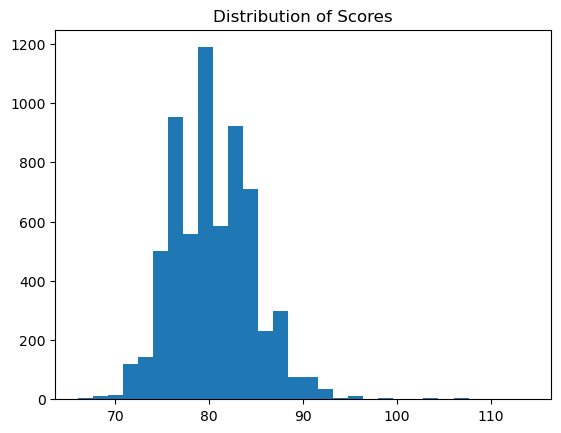

In [26]:
# confirming normal distribution of scores
plt.hist(df['score'], bins=30)
plt.title('Distribution of Scores')
plt.show()

In [27]:
print("Score Std Dev:", df['score'].std())

Score Std Dev: 4.4497501947832445


In [28]:
from sklearn.preprocessing import StandardScaler

# final feature engineering function to use for model
def feature_engineering(df):
    df['wind_precip'] = df['precipitation'] * df['wind_speed']
    df['wind_cold'] = df['wind_speed'] * (df['avg_temp'] < 15).astype(int)
    df['bad_weather_combo'] = ((df['wind_speed'] > 15) &
                           (df['precipitation'] > 0.5) &
                           (df['avg_temp'] < 15)).astype(int)
    df['weekend'] = (df['day_of_week_int'] >= 5)
    #df = pd.get_dummies(df, columns=['day_of_week_int'], prefix='day', drop_first=True)

    features_to_scale = ['round_number', 'handicap', 'avg_temp',
                   'precipitation', 'wind_speed']

    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    X = df.drop(['score'], axis=1)
    y = df['score']

    return X, y, scaler

In [29]:
# test and inspect results
X, y, scaler = feature_engineering(df)

In [34]:
X.head(5)

,round_number,handicap,avg_temp,precipitation,wind_speed,wind_precip,wind_cold,bad_weather_combo,weekend,day_2,day_3,day_4,day_5,day_6,day_7
0,-0.912213,1.023416,-0.873076,-0.264355,-0.717595,13.00,13.0,0,False,False,False,True,False,False,False
1,-0.850226,1.023416,0.277505,-0.264355,0.523461,19.80,0.0,0,True,False,False,False,True,False,False
2,-0.788239,1.023416,1.124460,-0.352186,0.651216,6.15,0.0,0,False,False,True,False,False,False,False
3,-0.726251,1.023416,-1.496307,0.601412,0.322702,147.73,18.7,1,False,True,False,False,False,False,False
4,-0.664264,1.023416,-0.489549,-0.389829,1.253494,0.00,23.8,0,False,False,True,False,False,False,False


In [33]:
y.shape

(6458,)